# Import appropriate modules

In [1]:
import numpy as np
from numpy import save, savez, savez_compressed, load
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import Rb87Cs133

import scipy.constants

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import Rb87Cs133

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.gridspec import GridSpec

# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
# plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}\usepackage{mathtools}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

# Define Helper Functions

In [2]:
def label_to_state_no(N,MF,k):
    return np.where((LABELS[:, 0] == N) & (LABELS[:, 1] == MF) & (LABELS[:, 2] == k))[0][0]

def state_no_to_uncoupled_label(state_no):
    i=0
    I1d = round(2*I1)
    I2d = round(2*I2)
    for n in range(0, N_MAX + 1):
        for mn in range(n,-(n+1),-1):
            for mi1 in range(I1d,-I1d-1,-2):
                for mi2 in range(I2d,-I2d-1,-2):
                    if i == state_no:
                        return (n,mn,mi1/2,mi2/2)
                    i+=1

In [3]:
def label_degeneracy(N,MF):
    # Want number of ways of having
    # MF = MN + (M_I1 + M_I2) # NP-Hard Problem SSP (Subset Sum)
    d=0
    I1d=round(2*I1)
    I2d=round(2*I2)
    for MN in range(-N,N+1):
        for M_I1d in range(-I1d,I1d+1,2):
            for M_I2d in range(-I2d,I2d+1,2):
                if 2*MN+M_I1d+M_I2d == 2*MF:
                    d+=1
    return d

In [4]:
def reachable_above_from(N,MF):
    sigma_plus_reachable = [(N+1,MF-1,i) for i in range(label_degeneracy(N+1,MF-1))]
    pi_reachable = [(N+1,MF,i) for i in range(label_degeneracy(N+1,MF))]
    sigma_minus_reachable = [(N+1,MF+1,i) for i in range(label_degeneracy(N+1,MF+1))]
    return (sigma_plus_reachable + pi_reachable + sigma_minus_reachable)

In [5]:
def twice_average_fidelity(k,g):
    return ((1 + g**2)**2 + 8*k**2*(-1 + 2*g**2) + 16*k**4)/((1 + g**2)**3 + (-8 + 20*g**2 + g**4)*k**2 + 16*k**4)

def maximum_fidelity(k,g):
    phi = np.arccos((k*(18-9*g**2-8*k**2))/(3+3*g**2+4*k**2)**(3/2))/3
    denominator = 54*((1+g**2)**3+(-8+20*g**2+g**4)*k**2+16*k**4)
    numerator = (
                 36*(g**4+(1-4*k**2)**2+2*g**2*(1+8*k**2))
               + 32*k    *(3+3*g**2+4*k**2)**(3/2) *np.cos(phi)
               - 64*k**2 *(3+3*g**2+4*k**2)        *np.cos(2*phi) 
               -  4      *(3+3*g**2+4*k**2)**2     *np.cos(4*phi)
                )
    return numerator/denominator

In [6]:
def trio_transfer_efficiency(state1_label,state2_label,state3_label,bi,pulse_time=0.0001):
    state1i = label_to_state_no(*state1_label)
    state2i = label_to_state_no(*state2_label)
    state3i = label_to_state_no(*state3_label)
    
    P = state1_label[1] - state2_label[1]
    COUPLING = COUPLINGS[P]
    
    g = np.abs(COUPLING[bi, state1i, state3i]/COUPLING[bi, state1i, state2i])
    k = np.abs(((ENERGIES[bi, state3i] - ENERGIES[bi, state2i]) / scipy.constants.h) / (1/pulse_time))
    sub_transfered = twice_average_fidelity(k,g)
    
    return sub_transfered

In [7]:
def transfer_efficiency(state1_label, state2_label,bi,pulse_time=0.0001):
    transfered = 1
    
    state1i = label_to_state_no(*state1_label)
    state2i = label_to_state_no(*state2_label)

    P = (state1_label[1] - state2_label[1])*(state2_label[0] - state1_label[0])
    COUPLING = COUPLINGS[P]
    
    for state3i in range(N_STATES):
        if state3i == state1i or state3i == state2i:
            continue
        g = np.abs(COUPLING[bi, state1i, state3i]/COUPLING[bi, state1i, state2i])
        k = np.abs(((ENERGIES[bi, state3i] - ENERGIES[bi, state2i]) / scipy.constants.h) / (1/pulse_time))
        sub_transfered = twice_average_fidelity(k,g)
        transfered *= sub_transfered
        
    return transfered

In [8]:
def fidelity(ts,d=8):
    return -np.log10(1-ts+10**(-d))

# Define parameters

In [9]:
H_BAR = scipy.constants.hbar

I1 = Rb87Cs133["I1"]
I2 = Rb87Cs133["I2"]
D_0 = Rb87Cs133["d0"]
N_MAX=2

I = 0 #W/m^2
E = 0 #V/m

B_MIN_GAUSS = 0.001
B_MAX_GAUSS = 1000
B_STEPS = 500
PULSE_TIME_US = 500

settings_string = f'NMax{N_MAX}BMin{B_MIN_GAUSS}BMax{B_MAX_GAUSS}BSteps{B_STEPS}PTime{PULSE_TIME_US}'
print(settings_string)

GAUSS = 1e-4 # T
B_MIN = B_MIN_GAUSS * GAUSS # T
B_MAX = B_MAX_GAUSS * GAUSS # T
PULSE_TIME = PULSE_TIME_US * 1e-6 # s

B, B_STEP_SIZE = np.linspace(B_MIN, B_MAX, B_STEPS, retstep=True) #T 

NMax2BMin0.001BMax1000BSteps500PTime500


In [10]:
data = np.load(f'../precomputed/{settings_string}.npz')
ENERGIES = data['energies']
N_STATES = len(ENERGIES[0])
STATES = data['states']
LABELS=data['labels']
MAGNETIC_MOMENTS=data['magnetic_moments'] 
COUPLINGS_ZERO=data['coupling_matrix_zero']
COUPLINGS_MINUS=data['coupling_matrix_minus']
COUPLINGS_PLUS=data['coupling_matrix_plus']
COUPLINGS = COUPLINGS_ZERO+COUPLINGS_MINUS+COUPLINGS_PLUS
UNPOLARISED_PAIR_FIDELITIES = data['unpolarised_pair_fidelities']
POLARISED_PAIR_FIDELITIES=data['polarised_pair_fidelities']

# Form sparse graph representation

In [38]:
from scipy.sparse import csgraph
AT_BI = 400
CONSIDERED_MATRIX = UNPOLARISED_PAIR_FIDELITIES[:,:,AT_BI] + UNPOLARISED_PAIR_FIDELITIES[:,:,AT_BI].T
G2_sparse = csgraph.csgraph_from_dense(-np.log(CONSIDERED_MATRIX), null_value=np.inf) # Expecting div 0 warning, this is fine

/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_87086/1728501512.py:4: RuntimeWarning: divide by zero encountered in log
  G2_sparse = csgraph.csgraph_from_dense(-np.log(CONSIDERED_MATRIX), null_value=np.inf) # Expecting div 0 warning, this is fine


# Show a bit of graph

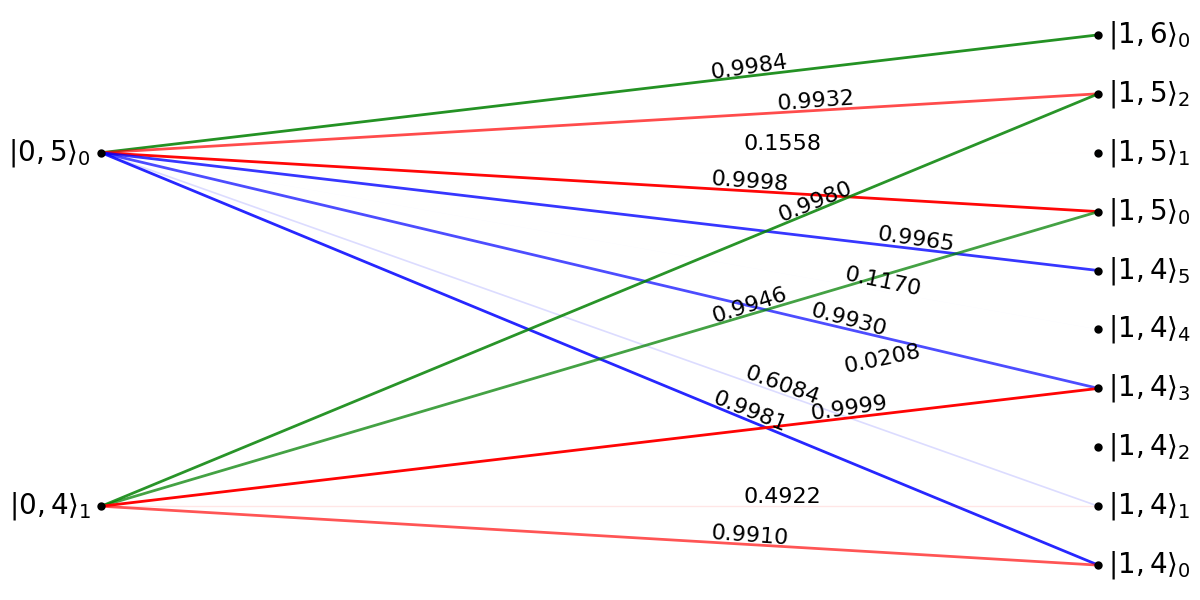

In [32]:
def label_to_position(label):
    n = round(label[0])
    mf = round(label[1])
    i = round(label[2])

    h=0
    for mf_loop in range(0,abs(mf)):
        h += label_degeneracy(n,mf_loop)
    h += i
    
    if mf<0:
        h=-h+label_degeneracy(n,0)-1
    
    x=n
    y=h/(5*(n)+1)
    if n==1:
        y+=8.5
    return x,y

fig,ax = plt.subplots(figsize = (6,3),constrained_layout=True)

interesting_states = [(0,5,0),(0,4,1),(1,6,0),(1,5,0),(1,5,1),(1,5,2),(1,4,0),(1,4,1),(1,4,2),(1,4,3),(1,4,4),(1,4,5)]
interesting_states_indices = [label_to_state_no(*label) for label in interesting_states]

pcol = ['red','green','blue']


for i in interesting_states_indices:
    for j in interesting_states_indices:
        if j<=i:
            continue
        
        start_label = LABELS[i]
        end_label = LABELS[j]
        if start_label[0] == end_label[0]:
            continue
        
        strength = CONSIDERED_MATRIX[i,j]
        if strength < 0.01:
            continue
        
        xstart,ystart = label_to_position(start_label)
        xend,yend = label_to_position(end_label)
        
        P = round((end_label[0]-start_label[0])*(end_label[1]-start_label[1]))
        this_pcol = pcol[P]
        ax.plot([xstart,xend],[ystart,yend],lw=strength,c=this_pcol,alpha=max(-np.log10(1-strength+1e-3)/3,0))
        grad = (yend-ystart)/(xend-xstart)
        x=0.75+(end_label[2]-3)/30
        y=x*grad+ystart
        rot=np.arctan((yend-ystart)/(xend-xstart))
        ax.text(x,y+0.025,f"{strength:.4f}",fontsize=8,rotation=rot*(80/np.pi),rotation_mode='default',va="center",ha="center")
        
        
for i in interesting_states_indices:
    this_label = LABELS[i]
    x,y = label_to_position(this_label)
    ax.plot([x],[y],'ko',markersize=2)
    ha="right" if this_label[0]==0 else "left"
    dx=-0.01 if this_label[0]==0 else 0.01
    ax.text(x+dx,y,r"$|{},{}\rangle_{{{}}}$".format(round(this_label[0]),round(this_label[1]),round(this_label[2])),c='black',fontsize=10,ha=ha,va="center")
    
plt.axis('off')
fig.savefig('../images/undirected-graph-sample.pdf')

# All-pairs shortest path

In [33]:
dist,pred = csgraph.shortest_path(G2_sparse,return_predecessors=True,directed=False)

In [34]:
STARTING_LABEL = (0,4,1)
STARTING_INDEX = label_to_state_no(*STARTING_LABEL)

TO_GO_LABEL = (0,3,0)
TO_GO_INDEX = label_to_state_no(*TO_GO_LABEL)

print("starting at",STARTING_LABEL, "index", STARTING_INDEX)
print("trying to go to                                       ",TO_GO_LABEL, "index", TO_GO_INDEX)

current_back = TO_GO_INDEX
while current_back != STARTING_INDEX:
    print(f"distance={dist[STARTING_INDEX][current_back]:.3f}, cumulativeTransfer={np.exp(-dist[STARTING_INDEX][current_back]):.3f}, priorLabel= {LABELS[pred[STARTING_INDEX][current_back]]}, priorIndex={pred[STARTING_INDEX][current_back]}")
    current_back = pred[STARTING_INDEX][current_back]

starting at (0, 4, 1) index 22
trying to go to                                        (0, 3, 0) index 5
distance=0.349, cumulativeTransfer=0.705, priorLabel= [1 2 8], priorIndex=103
distance=0.345, cumulativeTransfer=0.708, priorLabel= [0 1 2], priorIndex=15
distance=0.343, cumulativeTransfer=0.709, priorLabel= [1 1 7], priorIndex=82
distance=0.343, cumulativeTransfer=0.710, priorLabel= [ 2  1 12], priorIndex=216
distance=0.340, cumulativeTransfer=0.712, priorLabel= [1 1 8], priorIndex=92
distance=0.009, cumulativeTransfer=0.991, priorLabel= [0 2 3], priorIndex=24
distance=0.007, cumulativeTransfer=0.993, priorLabel= [1 3 2], priorIndex=55
distance=0.002, cumulativeTransfer=0.998, priorLabel= [0 4 1], priorIndex=22


In [35]:
label_degeneracies = np.zeros((N_MAX,round(N_MAX+I1+I2)+1))
for N in range(N_MAX):
    F=round(N+I1+I2)
    for MF in range(0,F+1):
        label_degeneracies[N,MF] = label_degeneracy(N,MF)
        
print(label_degeneracies[0])

[4. 4. 4. 3. 2. 1. 0. 0.]


Text(2, -15, 'N=2')

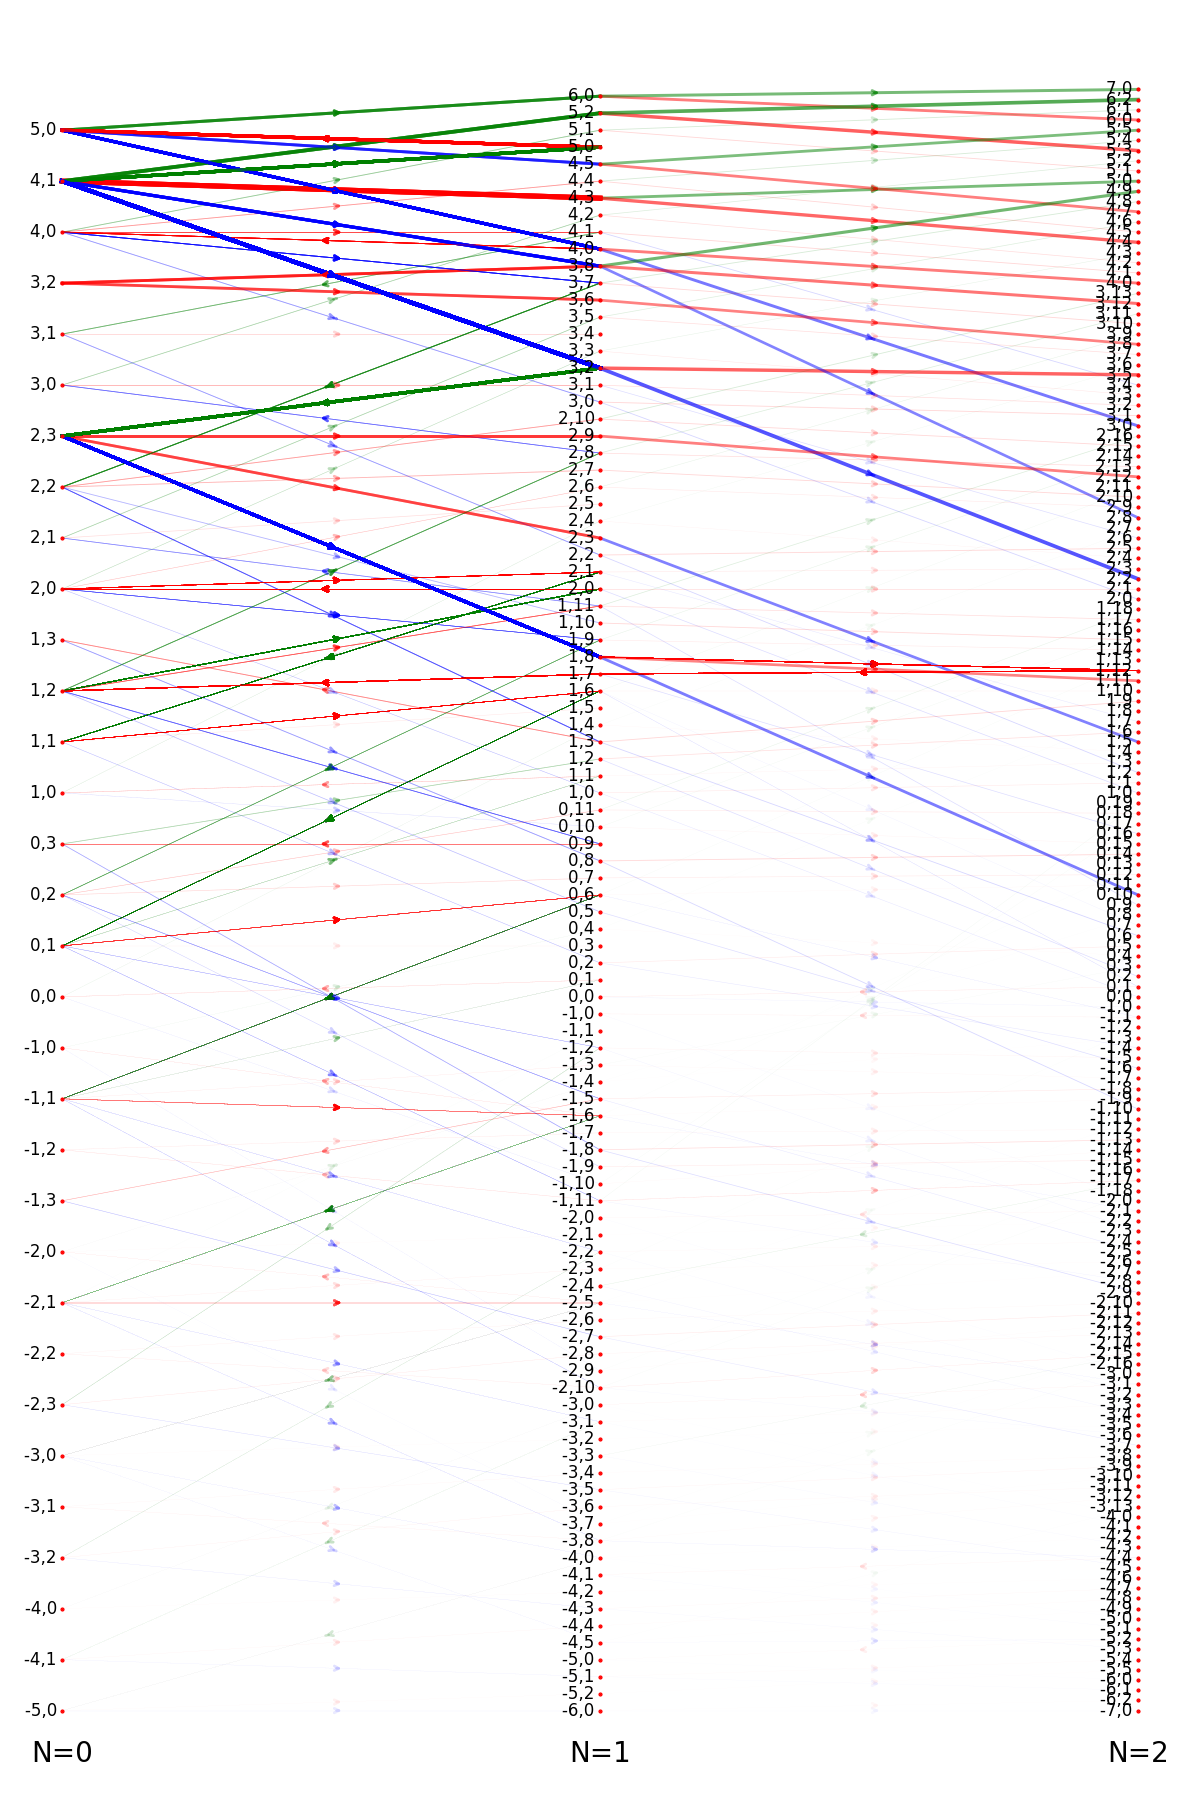

In [39]:
def label_to_position(label):
    n = round(label[0])
    mf = round(label[1])
    i = round(label[2])

    h=0
    for mf_loop in range(0,abs(mf)):
        h += label_degeneracy(n,mf_loop)
    h += i
    
    if mf<0:
        h=-h+label_degeneracy(n,0)-1
    
    x=n
    y=h/(2*n+1)
    return x,y

fig,ax = plt.subplots(figsize = (6,9),constrained_layout=True)

interesting_states = reachable_above_from(0,5)
interesting_states_indices = [label_to_state_no(*label) for label in interesting_states]

pcol = ['red','green','blue']

for i in range(N_STATES):
    current_back = i
    while current_back != STARTING_INDEX:
        cumulative_distance = np.exp(-dist[STARTING_INDEX][current_back])
        start_label = LABELS[current_back]
        xstart,ystart = label_to_position(start_label)
        current_back = pred[STARTING_INDEX][current_back]
        end_label = LABELS[current_back]
        xend,yend = label_to_position(end_label)
        P = round((end_label[0]-start_label[0])*(end_label[1]-start_label[1]))
        this_pcol = pcol[P]
        metric = cumulative_distance
        log_metric = max(0,-np.log10(1-cumulative_distance+1e-4)/4)
        line = ax.plot([xstart,xend],[ystart,yend],lw=log_metric*2,c=this_pcol,alpha=log_metric,aa=True)
        mean = ((xstart+xend)/2,(ystart+yend)/2)
        if xend<xstart:
            dx = (0.02,0.02*(yend-ystart)/(xend-xstart))
        else:
            dx = (-0.02,-0.02*(yend-ystart)/(xend-xstart))
        ax.annotate('',
            xytext=mean,
            xy=(mean[0]+dx[0], mean[1]+dx[1]),
            arrowprops=dict(arrowstyle="->", color=this_pcol,alpha=log_metric),
            size=4
        )
        
for i in range(N_STATES):
    this_label = LABELS[i]
    x,y = label_to_position(this_label)
    ax.plot([x],[y],'ro',markersize=0.5)
    ax.text(x,y,f"{round(this_label[1])},{round(this_label[2])} ",c='black',fontsize=6,ha="right",va="center")
    
plt.axis('off')
ax.text(0,-15,"N=0",ha="center")
ax.text(1,-15,"N=1",ha="center")
ax.text(2,-15,"N=2",ha="center")
# ax.set_xlim(3,15)
# fig.savefig('../images/all-to-all-states-shortest-path.pdf')